In [132]:
!pip install catboost

In [133]:
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split,  cross_val_score
from sklearn.metrics import classification_report, accuracy_score
import shap
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [134]:
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier


In [135]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [136]:
df = pd.read_csv('cardio_train.csv', sep=";")


In [137]:
df['age'] = df['age']/ 365

In [138]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,50.391781,2,168,62.0,110,80,1,1,0,0,1,0
1,1,55.419178,1,156,85.0,140,90,3,1,0,0,1,1
2,2,51.663014,1,165,64.0,130,70,3,1,0,0,0,1
3,3,48.282192,2,169,82.0,150,100,1,1,0,0,1,1
4,4,47.873973,1,156,56.0,100,60,1,1,0,0,0,0


In [139]:
df['bmi'] = df['weight'] / ((df['height']/100)**2)
df = df[(df['bmi'] >= 15) & (df['bmi'] <= 50)]

In [140]:
df['bmi'] = df['weight'] / ((df['height']/100)**2)
df = df[(df['bmi'] >= 15) & (df['bmi'] <= 50)]
df['pulse_pressure'] = df['ap_hi'] - df['ap_lo']
df['hypertension'] = ((df['ap_hi'] >= 140) | (df['ap_lo'] >= 90)).astype(int)
df['obesity'] = (df['bmi'] >= 30).astype(int)

df = df.drop(columns=['height', 'weight', 'ap_hi', 'ap_lo'])

<ipython-input-140-02bfc99c51b0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bmi'] = df['weight'] / ((df['height']/100)**2)


In [141]:
if 'id' in df.columns:
    df.drop(columns=['id'], inplace=True)


In [142]:
X = df.drop('cardio', axis=1)
y = df['cardio']


In [143]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [144]:
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns


numeric_cols = [col for col in numeric_cols if X[col].nunique() > 10]

non_numeric_cols = [col for col in X.columns if col not in numeric_cols]

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[numeric_cols])
X_test_num = scaler.transform(X_test[numeric_cols])

X_train_num_df = pd.DataFrame(X_train_num, columns=numeric_cols, index=X_train.index)
X_test_num_df = pd.DataFrame(X_test_num, columns=numeric_cols, index=X_test.index)

X_train_scaled = pd.concat([X_train_num_df, X_train[non_numeric_cols]], axis=1)
X_test_scaled = pd.concat([X_test_num_df, X_test[non_numeric_cols]], axis=1)

In [145]:
models = {
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "XGBoost": XGBClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVC": SVC(random_state=42),
    "KNeighbors": KNeighborsClassifier()
}

for model_name, model in models.items():
    scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='accuracy')
    print(f"{model_name} - Average CV Accuracy: {scores.mean()}")



CatBoost - Average CV Accuracy: 0.7315099364884244
XGBoost - Average CV Accuracy: 0.7283753329235813
Random Forest - Average CV Accuracy: 0.700020487604999
SVC - Average CV Accuracy: 0.7233558696988321
KNeighbors - Average CV Accuracy: 0.6880147510755993


In [146]:

best_model = CatBoostClassifier(verbose=0,random_state=42)

best_model.fit(X_train_scaled, y_train)

y_pred = best_model.predict(X_test_scaled)

print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.79      0.75     10434
           1       0.76      0.68      0.72     10485

    accuracy                           0.74     20919
   macro avg       0.74      0.74      0.73     20919
weighted avg       0.74      0.74      0.73     20919

Accuracy: 0.7352645919977054


In [147]:
model = CatBoostClassifier(verbose=0, random_state=42)
model.fit(X_train_scaled, y_train)


In [148]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train_scaled)



In [149]:
mean_shap = pd.DataFrame(shap_values, columns=X_train.columns).abs().mean()
important_features = mean_shap[mean_shap > 0.1].index.tolist()

print("Important features selected by SHAP:\n", important_features)



Important features selected by SHAP:
 ['age', 'gender', 'cholesterol', 'smoke', 'hypertension']


In [151]:
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

X_train_sel = X_train_scaled_df[important_features]
X_test_sel = X_test_scaled_df[important_features]

model_final = CatBoostClassifier(
    verbose=100,
    random_state=42,
    iterations= 500,
    learning_rate=0.001,
    depth=7,
    early_stopping_rounds=50,
    eval_metric='Accuracy'
)
model_final.fit(X_train_sel, y_train)

y_pred = model_final.predict(X_test_sel)
print("\n Classification Report:\n", classification_report(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))


0:	learn: 0.7203647	total: 11.3ms	remaining: 5.65s
100:	learn: 0.7204057	total: 1.23s	remaining: 4.84s
200:	learn: 0.7203647	total: 2.4s	remaining: 3.57s
300:	learn: 0.7208154	total: 3.57s	remaining: 2.36s
400:	learn: 0.7236222	total: 4.79s	remaining: 1.18s
499:	learn: 0.7233559	total: 6.92s	remaining: 0us

 Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.79      0.74     10434
           1       0.76      0.66      0.71     10485

    accuracy                           0.72     20919
   macro avg       0.73      0.72      0.72     20919
weighted avg       0.73      0.72      0.72     20919

Accuracy: 0.7238873751135332


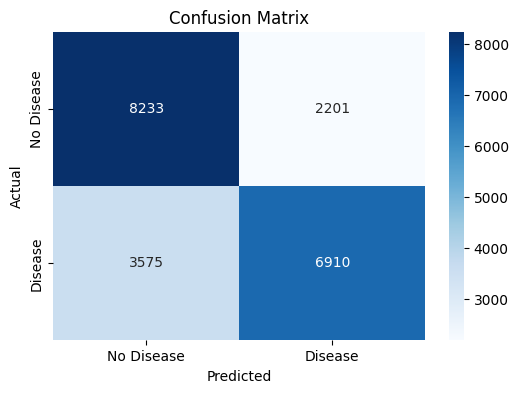

In [152]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No Disease", "Disease"], yticklabels=["No Disease", "Disease"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [153]:
#The model is fairly accurate but misses some people who actually have the disease.

# Learning Curve

In [154]:
from sklearn.model_selection import learning_curve
import numpy as np


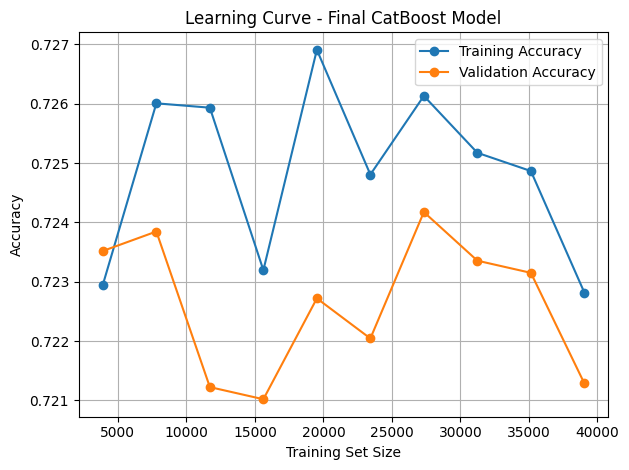

In [155]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

model_for_curve = CatBoostClassifier(
    verbose=0,
    random_state=42,
    iterations=500,
    learning_rate=0.001,
    depth=7,
    early_stopping_rounds=50,
    eval_metric='Accuracy'
)

train_sizes, train_scores, test_scores = learning_curve(
    model_for_curve,
    X_train_sel,
    y_train,
    cv=5,
    scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 10),
    n_jobs=-1
)


train_scores_mean = train_scores.mean(axis=1)
test_scores_mean = test_scores.mean(axis=1)

plt.plot(train_sizes, train_scores_mean, 'o-', label='Training Accuracy')
plt.plot(train_sizes, test_scores_mean, 'o-', label='Validation Accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve - Final CatBoost Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [161]:
X_train_scaled_df.head()

,age,gender,cholesterol,gluc,smoke,alco,active,bmi,pulse_pressure,hypertension,obesity
6255,0.360909,1,3,1,0,0,1,-0.495847,0.034803,0,0
10332,0.121589,1,1,3,0,0,1,1.167117,0.071518,0,1
55987,-0.785797,2,1,1,1,1,1,-0.140399,0.030723,0,0
3481,-0.590286,2,2,2,0,0,0,0.005712,0.030723,0,0
1723,0.374700,2,1,1,0,0,1,1.210065,0.071518,0,1


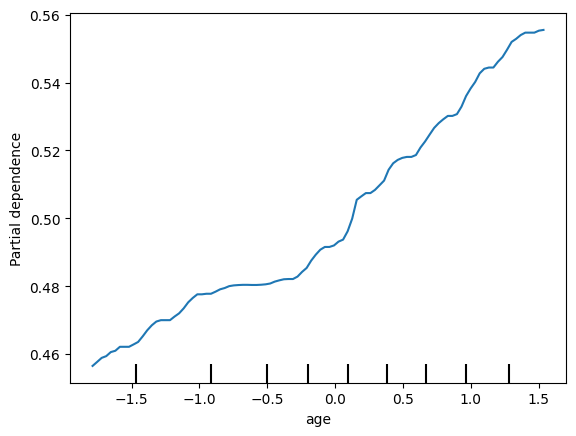

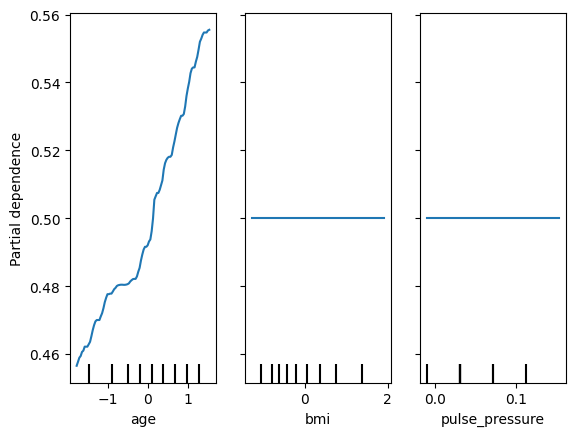

In [159]:
from sklearn.inspection import PartialDependenceDisplay
import matplotlib.pyplot as plt

# For one feature
PartialDependenceDisplay.from_estimator(
    model_final,
    X_train_scaled_df,
    features=['age']
)
plt.show()

# For multiple features
PartialDependenceDisplay.from_estimator(
    model_final,
    X_train_scaled_df,
    features=['age', 'bmi', 'pulse_pressure']
)
plt.show()



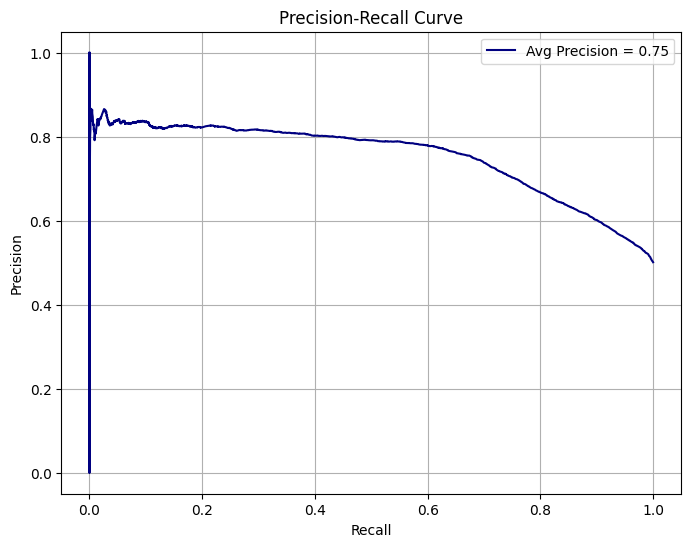

In [162]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

y_probs = model_final.predict_proba(X_test_sel)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, y_probs)
average_precision = average_precision_score(y_test, y_probs)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f"Avg Precision = {average_precision:.2f}", color='navy')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()
